In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as calc_eigen
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize as normalize_vectors
from sklearn.model_selection import GridSearchCV as CV

In [2]:
def extractTrainAndTestData(file_path, r, r2):
    """
    takes images and labels as input
    outputs training data and test data
    """
    mat = scipy.io.loadmat(file_path)
    X_train, X_test, y_train, y_test = train_test_split(mat['X'].T, mat['l'].T, test_size= r, random_state=r2, stratify = mat['l'].T)
    N_train = len(X_train[:,0])
    N_test = len(X_test[:,0])
    return X_train, y_train, N_train, X_test, y_test, N_test

def calculateAverageFace(X):
    """
    takes the training data set as input 
    and returns the average face
    """
    average_face= np.mean(X, axis=0)
    #plt.figure()
    #plt.title("Average Face")
    #plt.imshow(np.resize(average_face, (46, 56)).T, cmap='gray')
    return average_face

def normalize(X, AvgFace):
    """
    takes the training data set and average face as input 
    and returns the normalized training data set

    """
    N = len(X[:,0])
    Q = np.empty((N,2576))
    for index, face in enumerate(X):
        Q[index] = face - AvgFace
    return Q.T

def calculateCovarianceMatrix(Q):
    return np.matmul(Q,Q.T)/len(Q[0,:])

def calculateLowDimCovarianceMatrix(Q):
    return np.matmul(Q.T,Q)/len(Q[0,:])

def calculateEigenValuesAndVectors(S):
    """
    Takes covariance matrix as input
    and returns eigen values and vectors
    """
    v, w =  calc_eigen.eigh(S)
    #eigen_vectors[:,i] --> eigen_values[i]
    #eigen vector corresponding to eigen value

    #flips left to right... ascending to descending
    v = np.flip(v, axis=0) #turn ascending into descending
    w = np.flip(w, axis=1) #turn ascending into descending
    return v, w

def calculateWeights(Q, U):
    """
    takes input the normalized input and the eigen space
    outputs the weights of the normalized input
    """
    N = len(Q[0,:])
    W = np.empty((N,len(U[0, :])))
    for index, image in enumerate(Q.T):
        W[index] = np.matmul(image, U)
    return W

def calculateWeights2(Q, U):
    """
    alternative method to calculate weights
    """
    N = len(Q[0,:])
    W2 = np.empty((N,len(U[0, :])))
    W2 = np.matmul(Q.T, top_eigen_vectors)
    return W2

def printImage(face, title, saved_file):
    """
    takes input as the face you want to print, the title of the image, and the location of the file
    you would like to save the image to. 
    """
    plt.figure()
    plt.imshow(np.resize(face, (46, 56)).T, cmap='gray')
    plt.title(title)
    plt.savefig(saved_file, bbox_inches='tight')   # save the figure to file
    plt.show()
    plt.close() 
    
def plotEigenValueGraph(v, points):
    """
    plots eigen values against inrementing the number of eigen values used
    in descending order
    """
    y_points = [value for value in v[:points]]
    x_points = [i for i in range(points)]
    plt.xlabel('Number of Eigen Values')
    plt.ylabel('Eigen Values')
    plt.title('Plot of Eigen Values in Descending Order')
    plt.plot(x_points, y_points)
    plt.savefig('eigenvalues.png', bbox_inches='tight')   # save the figure to file
    plt.show()
    plt.close() 

In [3]:
file_path = 'face(1).mat'
M = 100
testRatio = 0.30
r2 = 73

X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio, r2)

def calculateEigenSpace(X_train, M):
    AvgFace = calculateAverageFace(X_train)
    A = normalize(X_train, AvgFace)
    S = calculateLowDimCovarianceMatrix(A)
    eigen_values, eigen_vectors = calculateEigenValuesAndVectors(S)
    #print("1: ", eigen_vectors.shape)
    eigen_vectors = normalize_vectors(np.matmul(A, eigen_vectors), axis=0)
    #print("2: ", eigen_vectors.shape)
    top_eigen_vectors = eigen_vectors[:, :M]
    #print("3: ", top_eigen_vectors.shape)
    return AvgFace, A, eigen_values, top_eigen_vectors

AvgFace, A, EigenValues, EigenSpace = calculateEigenSpace(X_train, M)
Weights =  calculateWeights(A, EigenSpace)

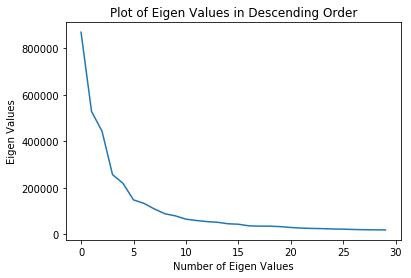

In [4]:
x_points = 30
plotEigenValueGraph(EigenValues, x_points)

In [5]:
np.sum(EigenValues[:390])*100/np.sum(EigenValues)

100.0

### Reconstruction

In [6]:
def reconstruction(weight, average_face, w):
    return (average_face + np.dot(w, weight.T))

In [7]:
# picking one face and it's corresponding weight for reconstruction
random_index = 5
face_to_be_reconstructed = X_train[random_index, :]
weights_of_face_to_be_reconstructed = Weights[random_index, :]

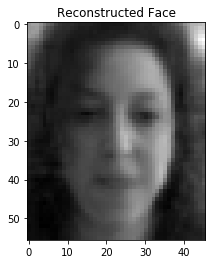

In [8]:
reconstructed_face = reconstruction(weights_of_face_to_be_reconstructed, AvgFace, EigenSpace)
#printImage(face_to_be_reconstructed, "Original Face", "original_face.png")
printImage(reconstructed_face, "Reconstructed Face", "reconstructed_face2.png")

In [9]:
error = reconstructed_face - face_to_be_reconstructed

In [10]:
calc_eigen.norm(error)

314.19223664722057

# Recognition

### NN Classification (self built functions)

In [11]:
def NNClassification(r, 
                     y_train, W_train, X_train, 
                     y_test, W_test, X_test):
    
    weight_test = W_test[r, :]
    face_test = X_test[r, :]
    face_test_label = y_test[r, :]
    error = np.empty(( len(W_train[:, 0]) ))
    for index, weight in enumerate(W_train): 
        error[index] = calc_eigen.norm(weight_test - weight)
    min_error = error.min()
    min_error_index = error.argmin()
    face_best_matched = X_train[min_error_index, :]
    label_best_matched = y_train[min_error_index, :]
    print(face_test_label, '--->', label_best_matched)
    if label_best_matched != face_test_label:
        return 1
    else:
        return 0

In [12]:
A_test = normalize(X_test, AvgFace) #normalize the test data
W_test = calculateWeights(A_test, EigenSpace) #calculate weights of the test data 
totalErrors = 0
for r in range(N_test):
    totalErrors += NNClassification(r, y_train, Weights, X_train, y_test, W_test, X_test)
E_out = totalErrors/N_test
print(E_out*100)

[8] ---> [8]
[45] ---> [5]
[32] ---> [32]
[42] ---> [16]
[41] ---> [40]
[45] ---> [45]
[43] ---> [36]
[22] ---> [12]
[42] ---> [42]
[50] ---> [50]
[11] ---> [30]
[26] ---> [26]
[40] ---> [35]
[19] ---> [24]
[30] ---> [17]
[49] ---> [6]
[47] ---> [44]
[28] ---> [46]
[1] ---> [1]
[18] ---> [20]
[27] ---> [29]
[36] ---> [48]
[14] ---> [14]
[48] ---> [41]
[17] ---> [17]
[6] ---> [10]
[38] ---> [49]
[39] ---> [39]
[3] ---> [3]
[45] ---> [45]
[15] ---> [15]
[21] ---> [21]
[13] ---> [13]
[27] ---> [27]
[9] ---> [9]
[18] ---> [18]
[47] ---> [21]
[16] ---> [16]
[33] ---> [33]
[18] ---> [18]
[32] ---> [49]
[7] ---> [1]
[37] ---> [37]
[20] ---> [20]
[2] ---> [5]
[19] ---> [4]
[33] ---> [33]
[44] ---> [29]
[2] ---> [32]
[2] ---> [5]
[13] ---> [19]
[52] ---> [52]
[52] ---> [52]
[34] ---> [40]
[3] ---> [3]
[10] ---> [10]
[48] ---> [48]
[9] ---> [9]
[15] ---> [21]
[24] ---> [24]
[51] ---> [51]
[26] ---> [26]
[16] ---> [16]
[9] ---> [9]
[29] ---> [21]
[51] ---> [25]
[6] ---> [6]
[23] ---> [23]
[21] --

In [13]:
len(EigenSpace[0, :])

100

### NN Classification #2 (Inbuilt Functions Used)

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
def NNClassification(file_path, testRatio, M, r2):
    X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio, r2)
    neigh = KNeighborsClassifier(n_neighbors = 1)
    #preparing the training data
    AvgFace, A, EigenValues, EigenSpace = calculateEigenSpace(X_train, M) #calculating eigen space
    W_train =  calculateWeights(A, EigenSpace) #calculating the weights of training set using eigen space
    #preparing the test data
    A_test = normalize(X_test, AvgFace) #normalize the test data
    W_test = calculateWeights(A_test, EigenSpace) #calculate weights of the test data 
    neigh.fit(W_train, y_train) 
    neigh.predict(W_test)
    return neigh.score(W_test, y_test)

In [16]:
file_path = 'face(1).mat'
M = [1, 3, 5, 10, 50, 100, 200, 300, 363]
testRatio = 0.30
r2 = 73
for m_val in M: 
    acc = NNClassification(file_path, testRatio, m_val, r2)
    print("Accuracy for: ", m_val, " is: " , acc)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Accuracy for:  1  is:  0.07051282051282051
Accuracy for:  3  is:  0.14743589743589744
Accuracy for:  5  is:  0.3076923076923077
Accuracy for:  10  is:  0.46794871794871795
Accuracy for:  50  is:  0.6346153846153846
Accuracy for:  100  is:  0.6153846153846154
Accuracy for:  200  is:  0.6282051282051282
Accuracy for:  300  is:  0.6346153846153846
Accuracy for:  363  is:  0.6410256410256411


### Alternative Recognition

In [17]:
def AlternativeMethod(file_path, M, testRatio, r2):
    X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio, r2)
    noOfClasses = 52
    reconstrErrors = np.empty((N_test, noOfClasses))
    d = {}

    for i in range(1, noOfClasses+1): #for each class    
        d["X_train_" + str(i)] = X_train[np.where(y_train == i)[0]]
        N = len(d["X_train_" + str(i)][:,0])
        #print("shape: ", d["X_train_" + str(i)].shape)
        AvgFace, normalized_Input, EigenValues, topEigenVectors = calculateEigenSpace(d["X_train_" + str(i)], M)
        #weights = calculateWeights(M, normalized_Input, topEigenVectors)
        weight_test = np.matmul(normalize(X_test, AvgFace).T, topEigenVectors)
        #print(topEigenVectors.shape)
        for index, weight in enumerate(weight_test):
            reconstructed_face = AvgFace + np.dot(topEigenVectors, weight.T)
            reconstruction_error = calc_eigen.norm(X_test[index] - reconstructed_face)
            reconstrErrors[index, i-1] = reconstruction_error 
            
    total_error = 0
    for index, face in enumerate(reconstrErrors):
        original_class = y_test[index, :]
        min_error = face.min()
        min_error_index = face.argmin()
        #print(original_class, '-->', min_error_index+1)
        class_matched = min_error_index+1
        if original_class != class_matched:
            total_error +=1
            
    return 100 - (total_error*100/N_test)

In [18]:
file_path = 'face(1).mat'
M = [1, 2, 3, 4, 5, 6]
for m_val in M: 
    acc = AlternativeMethod(file_path, m_val, testRatio, r2)
    print("Accuracy for: ", m_val, " is: " , acc)

Accuracy for:  1  is:  57.69230769230769
Accuracy for:  2  is:  67.94871794871796
Accuracy for:  3  is:  71.7948717948718
Accuracy for:  4  is:  71.7948717948718
Accuracy for:  5  is:  71.15384615384616
Accuracy for:  6  is:  70.51282051282051


# LDA-PCA

In [27]:
def compute_class_means():
    class_means={} #dict containing m1, m2, m3, ... (the mean of each class), as well as the global mean m
    for class_i in range(1, 53):
        class_means["m_" + str(class_i)] = np.mean(X_train[np.where(y_train == class_i)[0]], axis=0)
    class_means["m"] = calculateAverageFace(X_train)
    return class_means

def compute_S_b(class_means, M_pca):
    S_b = np.empty((2576, 2576))
    for class_i in range(1, 53):
        S_b += np.dot((class_means["m_" + str(class_i)] - class_means["m"]).reshape(2576,1), (class_means["m_" + str(class_i)] - class_means["m"]).reshape((1, 2576)))
    return S_b

def compute_S_w(class_means, M_pca):
    S_w = np.empty((2576, 2576))
    for class_i in range(1, 53):
        for image in X_train[np.where(y_train == class_i)[0]]:
            S_w += np.dot((image - class_means["m_" + str(class_i)]).reshape(2576,1), (image - class_means["m_" + str(class_i)]).reshape(1,2576))
    return S_w

def calculateGeneralisedEigenvectors(denominator, numerator, M):
    V, W = calculateEigenValuesAndVectors(np.matmul(np.linalg.inv(denominator), numerator))
    #plotEigenValueGraph(eigen_values, 100)
    W = normalize_vectors(W, axis=0)
    W = W[:, :M]
    return W

def NNClassification_weights(W_train, W_test, y_train, y_test):
    neigh = KNeighborsClassifier(n_neighbors = 1)
    neigh.fit(W_train, y_train) 
    neigh.predict(W_test)
    return neigh

In [155]:
def PCA_LDA(file_path, testRatio, M_pca, M_lda, r2):
    X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio, r2)
    #W_pca
    AvgFace, A_train, EigenValues, EigenSpace = calculateEigenSpace(X_train, M_pca)
    W_pca = EigenSpace
    
    #calculate S_w and S_b
    class_means = compute_class_means()
    S_b = compute_S_b(class_means, M_pca)
    S_w = compute_S_w(class_means, M_pca)
    #W_lda
    W_lda = calculateGeneralisedEigenvectors(np.linalg.multi_dot([W_pca.T, S_w, W_pca]), np.linalg.multi_dot([W_pca.T, S_b, W_pca]), M_lda)
    
    #W_opt
    W_opt = np.matmul(W_lda.T, W_pca.T).T
    
    A_test = normalize(X_test, AvgFace)
    #Classification
    W_train = np.matmul(A_train.T, W_opt) #calculate weights of training data
    W_test = np.dot(A_test.T, W_opt) #calculate weights of the test data 
    print(len(y_train), W_train.shape)
    neigh = NNClassification_weights(W_train, W_test, y_train, y_test)
    acc = neigh.score(W_test, y_test)
    return acc

In [156]:
file_path = 'face(1).mat'
M_pca = 150
testRatio = 0.30
M_lda = 51
random_state = 73


acc = PCA_LDA(file_path, testRatio, M_pca, M_lda, random_state)
acc

364 (364, 51)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.7435897435897436

### Cross Validation

In [22]:
M_pca = [130, 140, 150, 160, 170, 180]
M_lda = 51

#for pca, lda in zip(M_pca, M_lda):
for pca in M_pca:
    #M_lda = [int(pca*0.25), int(pca*0.5), int(pca*0.75)]
    acc = PCA_LDA(file_path, testRatio, pca, M_lda, random_state)
    print("M_pca: ", pca, " & M_lda: ", M_lda, " return accuracy: ",acc)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


M_pca:  130  & M_lda:  51  return accuracy:  0.717948717948718
M_pca:  140  & M_lda:  51  return accuracy:  0.7243589743589743
M_pca:  150  & M_lda:  51  return accuracy:  0.7435897435897436
M_pca:  160  & M_lda:  51  return accuracy:  0.7307692307692307
M_pca:  170  & M_lda:  51  return accuracy:  0.7243589743589743
M_pca:  180  & M_lda:  51  return accuracy:  0.717948717948718


In [25]:
M_pca = [175, 190, 200, 210, 225]
M_lda = 51

#for pca, lda in zip(M_pca, M_lda):
for pca in M_pca:
    #M_lda = [int(pca*0.25), int(pca*0.5), int(pca*0.75)]
    acc = PCA_LDA(file_path, testRatio, pca, M_lda, random_state)
    print("M_pca: ", pca, " & M_lda: ", M_lda, " return accuracy: ",acc)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


M_pca:  175  & M_lda:  51  return accuracy:  0.7243589743589743
M_pca:  190  & M_lda:  51  return accuracy:  0.7115384615384616
M_pca:  200  & M_lda:  51  return accuracy:  0.7307692307692307
M_pca:  210  & M_lda:  51  return accuracy:  0.7307692307692307
M_pca:  225  & M_lda:  51  return accuracy:  0.7243589743589743


In [ ]:
M_pca = [100, 120, 130, 140, 150, 170, 200]
M_lda = 51
testRatio = 0.30

for pca in M_pca:
    #M_lda = [int(pca*0.25), int(pca*0.5), int(pca*0.75)]
    acc = PCA_LDA(file_path, testRatio, pca, M_lda)
    print("M_pca: ", pca, " & M_lda: ", M_lda, " return accuracy: ",acc)

In [ ]:
M_pca = [100, 120, 130, 140, 150, 170, 200]
M_lda = 45
testRatio = 0.30

for pca in M_pca:
    #M_lda = [int(pca*0.25), int(pca*0.5), int(pca*0.75)]
    acc = PCA_LDA(file_path, testRatio, pca, M_lda)
    print("M_pca: ", pca, " & M_lda: ", M_lda, " return accuracy: ",acc)

### ------------------------------------------------------------------------------------------------------------------------------------

### Part 1: PCA

In [ ]:
#calculate the eigen space for training set using PCA (W_pca = EigenSpace)
AvgFace, A, EigenValues, EigenSpace = calculateEigenSpace(X_train, M_pca)
W_pca = EigenSpace

### Part 2: LDA

In [ ]:
#calculate S_w and S_b
class_means = compute_class_means()
S_b = compute_S_b(class_means, M_pca)
S_w = compute_S_w(class_means, M_pca)

### Part 3: Combining PCA with LDA

In [ ]:
#computation of W_pca.T*S_b*W_pca
numerator = np.linalg.multi_dot([W_pca.T, S_b, W_pca])

In [ ]:
#computation of W_pca.T*S_w*W_pca
denominator = np.linalg.multi_dot([W_pca.T, S_w, W_pca])

In [ ]:
W_lda = calculateGeneralisedEigenvectors(denominator, numerator, M_lda)

### 4. Calculating W_opt

In [ ]:
W_opt = np.matmul(W_lda.T, W_pca.T).T

In [ ]:
W_opt.shape

In [ ]:
for i in range(0, 21):
    printImage(W_opt[:, i], "Eigen Vector "+str(i), "reconstructed_face2.png")

### 5. NN Classification

In [ ]:
W_train = np.matmul(X_train, W_opt) #calculate weights of training data
W_test = np.dot(X_test, W_opt) #calculate weights of the test data 

In [ ]:
accuracy = NNClassification_weights(W_train, W_test, y_train, y_test)
accuracy

# PCA-LDA Ensemble

In [222]:
import random

def basic_bagging(images, c1): #implements bagging (with replacement)
    bagged_images = []
    for i in range(0, c1):
        rand_index = random.randint(0,c1-1)
        bagged_images.append(images[rand_index])
    return bagged_images

def create_one_replicate(file_path, testRatio, r2, c1): #creates a single replicate containing c1 images from each of the 52 classes
    X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio, r2)
    replicate = np.empty((0, 2576))
    replicate_labels = []
    for class_i in range(1, 53):
        class_i_images = X_train[np.where(y_train == class_i)[0]]
        bagged_class_i = basic_bagging(class_i_images, c1)
        bagged_class_i = convert_list_to_numpy_array(bagged_class_i)
        replicate = np.concatenate((replicate, bagged_class_i), axis=0)
        for i in range(0,c1):
            replicate_labels.append(class_i)
    return replicate, replicate_labels

def convert_list_to_numpy_array(myList):
    myArray = np.array(myList)
    return myArray

X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio, r2)
def PCA_LDA_new(X_train, y_train, X_test, y_test, M_pca, M_lda):        
    #W_pca
    AvgFace, A_train, EigenValues, EigenSpace = calculateEigenSpace(X_train, M_pca)
    W_pca = EigenSpace
    
    #calculate S_w and S_b
    class_means = compute_class_means()
    S_b = compute_S_b(class_means, M_pca)
    S_w = compute_S_w(class_means, M_pca)
    #W_lda
    W_lda = calculateGeneralisedEigenvectors(np.linalg.multi_dot([W_pca.T, S_w, W_pca]), np.linalg.multi_dot([W_pca.T, S_b, W_pca]), M_lda)
    
    #W_opt
    W_opt = np.matmul(W_lda.T, W_pca.T).T
    
    A_test = normalize(X_test, AvgFace)
    #Classification
    W_train = np.matmul(A_train.T, W_opt) #calculate weights of training data
    W_test = np.dot(A_test.T, W_opt) #calculate weights of the test data 
    neigh = NNClassification_weights(W_train, W_test, y_train, y_test)
    acc = neigh.score(W_test, y_test)
    return neigh.predict(W_test)

def calc_accuracy(predictions, y_test):
    return np.sum(predictions==np.squeeze(y_test))/len(y_test)*100

In [227]:
file_path = 'face(1).mat'
M_pca = 200
testRatio = 0.30
M_lda = 51
random_state = 73

c1 = 7

T = 20 #number of replicates
all_replicates = []
all_replicates_labels = []
for i in range(0, T):
    replicate, replicate_labels = create_one_replicate(file_path, testRatio, random_state, c1)
    #print(replicate.shape, len(replicate_labels))
    all_replicates.append(replicate)
    all_replicates_labels.append(replicate_labels)

all_predictions = np.empty((T, len(X_test)))

for i in range(0, len(all_replicates)):
    this_replicate_classifier = PCA_LDA_new(all_replicates[i], all_replicates_labels[i], X_test, y_test, M_pca, M_lda)
    print(i)
    all_predictions[i] = this_replicate_classifier

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [228]:
predictions = np.empty((len(X_test),))
for i, row in enumerate(all_predictions.T):
    counts = np.bincount(row.astype(int))
    predictions[i] = np.argmax(counts)
predictions
calc_accuracy(predictions, y_test)

72.43589743589743

In [186]:
all_predictions.shape

(156, 10)

In [226]:
print(np.sum(predictions==np.squeeze(y_test))/len(y_test)*100)

70.51282051282051
